# Installs & Imports

In [1]:
# Install packages
packages <- c(
    "MASS",
    "lme4",
    "TMB",
    "aghq",
    "performance",
    "Metrics",
    "DHARMa",
    "loo",
    "microbenchmark",
    "broom.mixed",
    "fastGHQuad"
)

for (pkg in packages) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        install.packages(pkg)
    }
}

In [2]:
# Load packages
suppressPackageStartupMessages({
    library(MASS)
    library(lme4)
    library(TMB)
    library(aghq)
    library(performance)
    library(Metrics)
    library(DHARMa)
    library(loo)
    library(microbenchmark)
    library(broom.mixed)
    library(dplyr)
    library(tidyr)
    library(tibble)
    library(fastGHQuad)
    library(ggplot2)
})

# Data Loading

In [3]:
# Load the epil data
data("epil", package = "MASS")
head(epil)
cat("\n")
str(epil)

,y,trt,base,age,V4,subject,period,lbase,lage
,<dbl>,<fct>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,5,placebo,11,31,0,1,1,-0.7563538,0.11420370
2,3,placebo,11,31,0,1,2,-0.7563538,0.11420370
3,3,placebo,11,31,0,1,3,-0.7563538,0.11420370
4,3,placebo,11,31,1,1,4,-0.7563538,0.11420370
5,3,placebo,11,30,0,2,1,-0.7563538,0.08141387
6,5,placebo,11,30,0,2,2,-0.7563538,0.08141387



'data.frame':	236 obs. of  9 variables:
 $ y      : num  5 3 3 3 3 5 3 3 2 4 ...
 $ trt    : Factor w/ 2 levels "placebo","progabide": 1 1 1 1 1 1 1 1 1 1 ...
 $ base   : int  11 11 11 11 11 11 11 11 6 6 ...
 $ age    : int  31 31 31 31 30 30 30 30 25 25 ...
 $ V4     : int  0 0 0 1 0 0 0 1 0 0 ...
 $ subject: int  1 1 1 1 2 2 2 2 3 3 ...
 $ period : int  1 2 3 4 1 2 3 4 1 2 ...
 $ lbase  : num  -0.756 -0.756 -0.756 -0.756 -0.756 ...
 $ lage   : num  0.1142 0.1142 0.1142 0.1142 0.0814 ...


In [4]:
# Counts for each treatment arm
trt_counts <- epil %>%
    count(
        trt,
        name = "n_obs"
    ) %>%
    mutate(
        prop = n_obs / sum(n_obs)
    )

trt_counts

trt,n_obs,prop
<fct>,<int>,<dbl>
placebo,112,0.4745763
progabide,124,0.5254237


In [5]:
# Summary by treatment (y, base, age)
epil_by_trt <- epil %>%
    group_by(trt) %>%
    summarise(
        N = n(),
        mean_y = mean(y, na.rm = TRUE),
        sd_y = sd(y, na.rm = TRUE),
        median_y = median(y, na.rm = TRUE),
        iqr_y = IQR(y, na.rm = TRUE),
        mean_base = mean(base, na.rm = TRUE),
        sd_base = sd(base, na.rm = TRUE),
        mean_age = mean(age, na.rm = TRUE),
        sd_age = sd(age, na.rm = TRUE),
        .groups = "drop"
    )

epil_by_trt

trt,N,mean_y,sd_y,median_y,iqr_y,mean_base,sd_base,mean_age,sd_age
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
placebo,112,8.598214,10.39270,5,9,30.78571,25.74911,29.00000,5.918364
progabide,124,7.959677,13.92979,4,6,31.61290,27.63841,27.74194,6.521847


In [6]:
# Per-subject seizure totals and observation counts
subject_summary <- epil %>%
    group_by(subject) %>%
    summarise(
        obs = n(),
        total_y = sum(y, na.rm = TRUE),
        avg_y = mean(y, na.rm = TRUE),
        .groups = "drop"
    )

subject_summary

subject,obs,total_y,avg_y
<int>,<int>,<dbl>,<dbl>
1,4,14,3.50
2,4,14,3.50
3,4,11,2.75
4,4,13,3.25
5,4,55,13.75
6,4,22,5.50
7,4,12,3.00
8,4,95,23.75
9,4,22,5.50


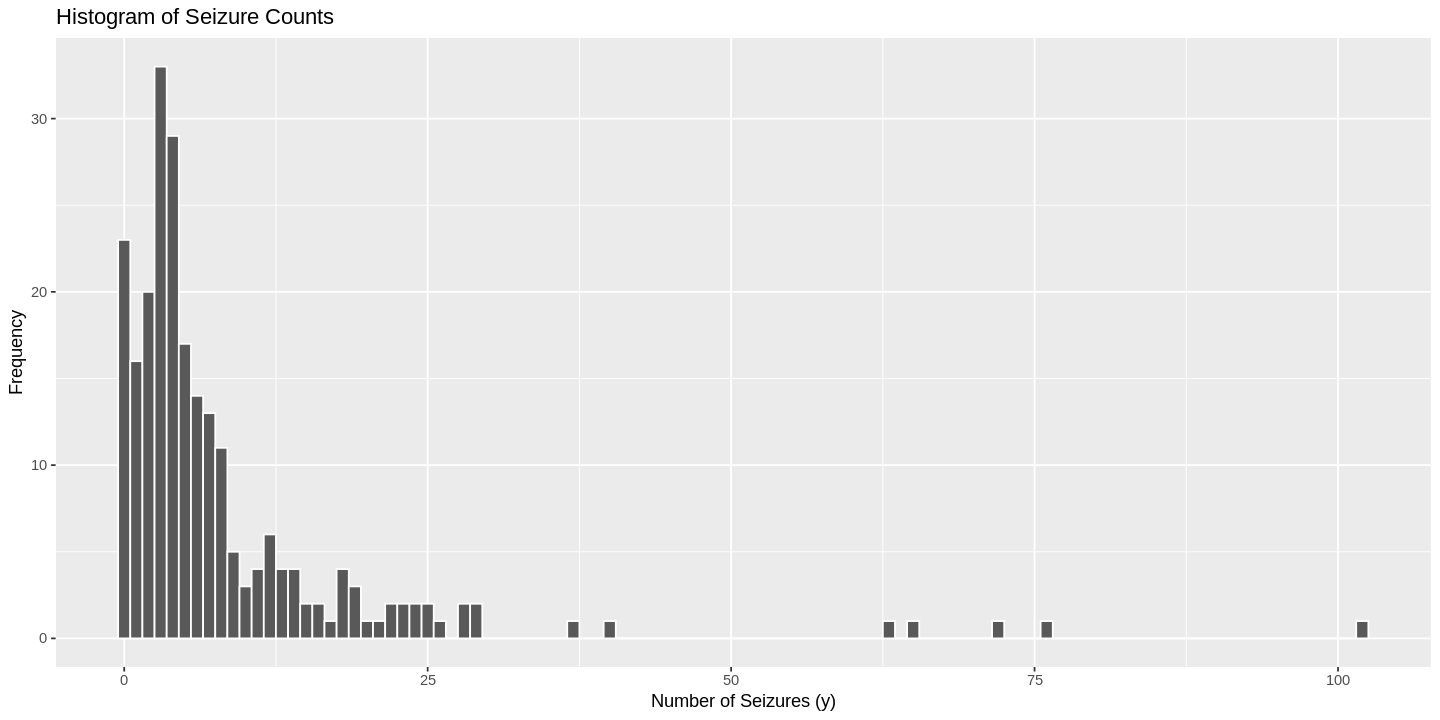

In [7]:
# Overall distribution of seizure counts (y)
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(epil, aes(x = y)) +
    geom_histogram(binwidth = 1, color = "white") +
    labs(
      title = "Histogram of Seizure Counts",
      x = "Number of Seizures (y)",
      y = "Frequency"
    )

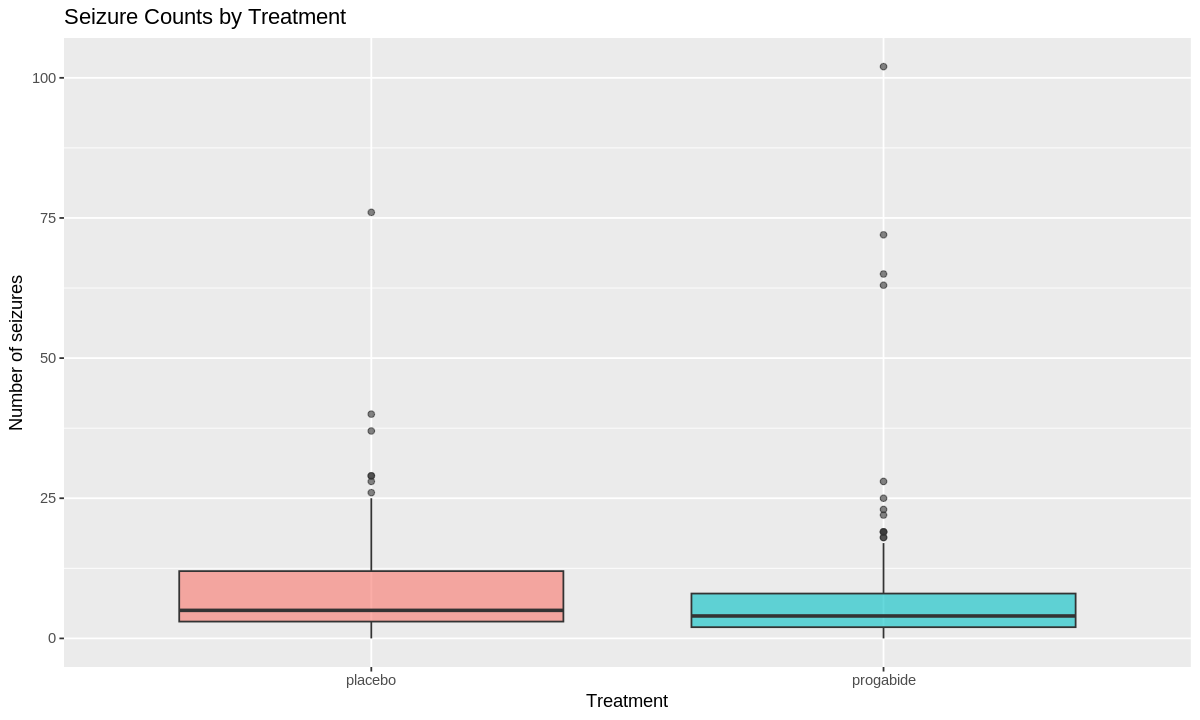

In [8]:
# Boxplot of counts by treatment arm
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(epil, aes(x = trt, y = y, fill = trt)) +
    geom_boxplot(alpha = 0.6) +
    labs(
      title = "Seizure Counts by Treatment",
      x = "Treatment",
      y = "Number of seizures"
    ) +
    theme(legend.position = "none")

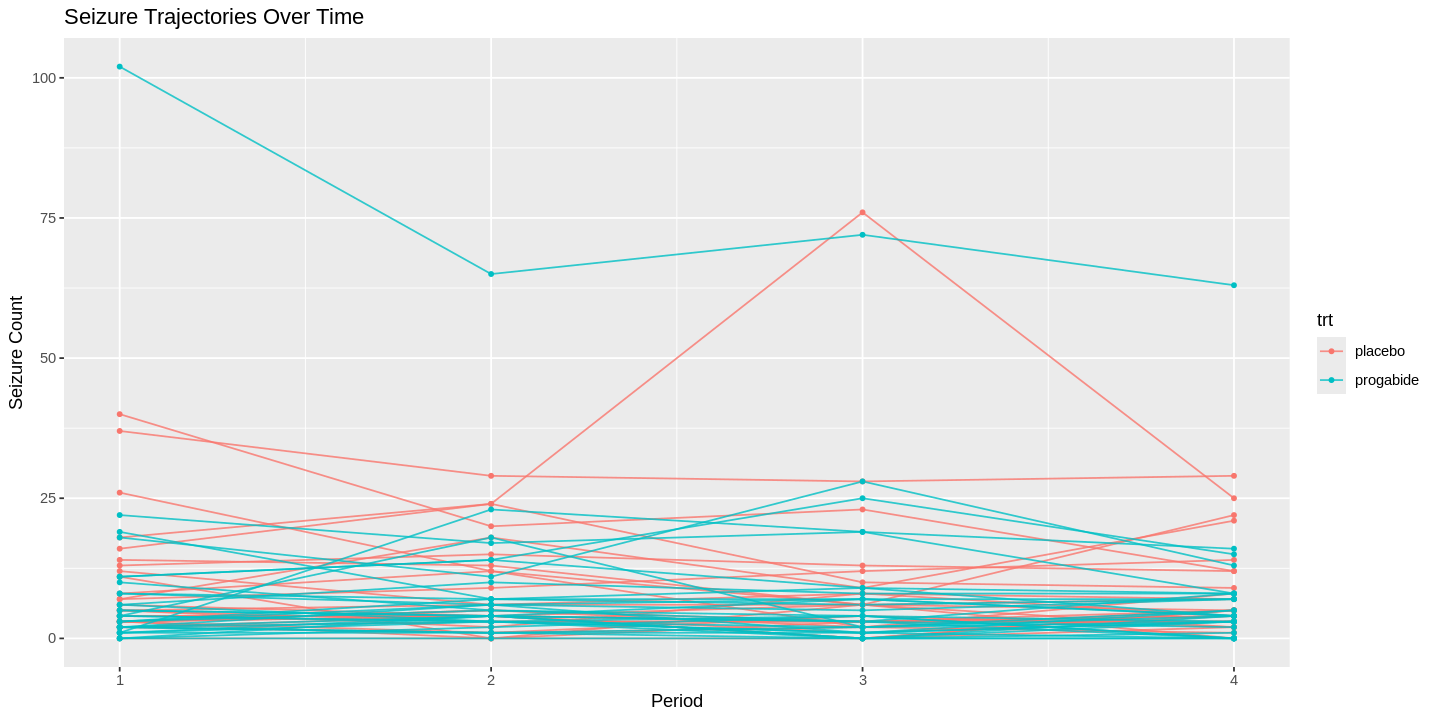

In [9]:
# Spaghetti plot: individual trajectories over study periods
options(repr.plot.width = 12, repr.plot.height = 6)
set.seed(2025)
sample_subj <- sample(unique(epil$subject), 59)

ggplot(
    filter(epil, subject %in% sample_subj),
    aes(x = period, y = y, group = subject, color = trt)
) +
    geom_line(alpha = 0.8) +
    geom_point(size = 1) +
    labs(
      title = "Seizure Trajectories Over Time",
      x = "Period",
      y = "Seizure Count"
    )

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


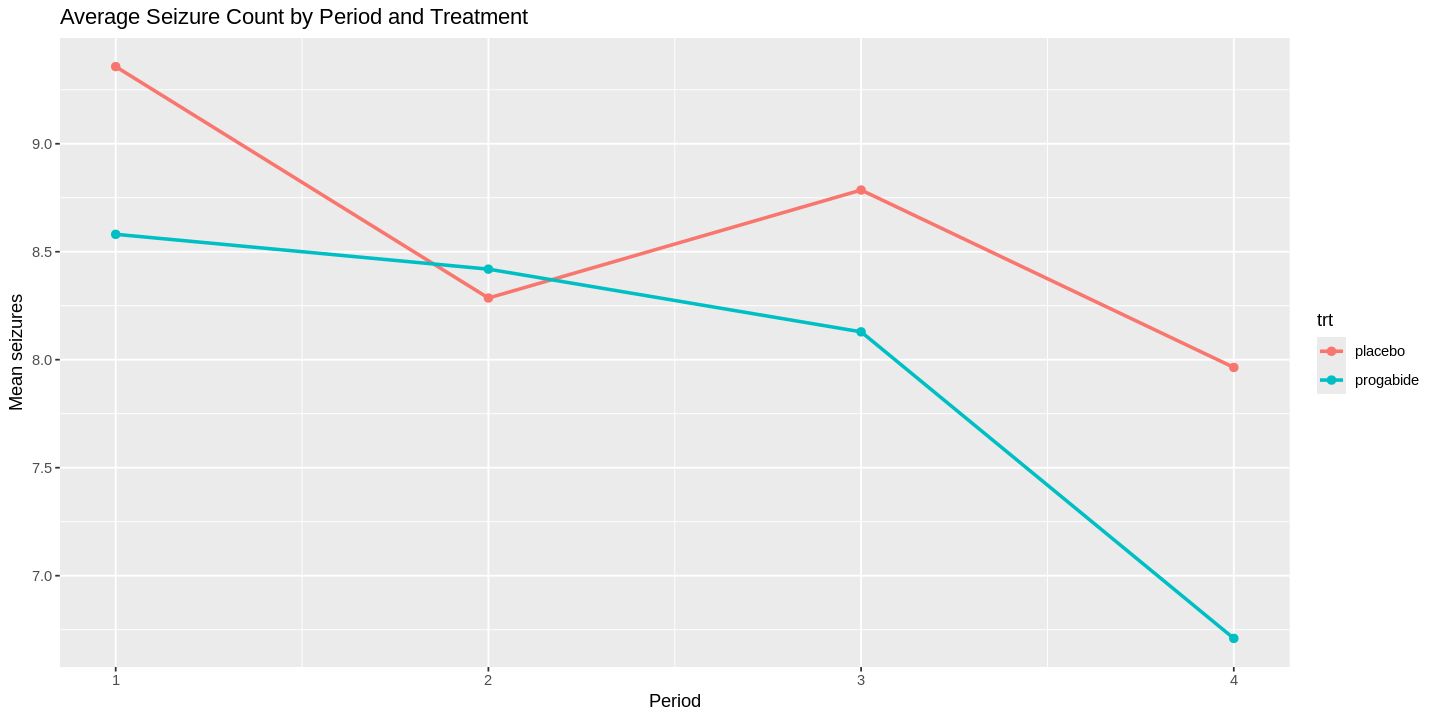

In [10]:
# Mean trend by treatment arm
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(epil, aes(x = period, y = y, color = trt)) +
    stat_summary(fun = mean, geom = "line", size = 1) +
    stat_summary(fun = mean, geom = "point", size = 2) +
    labs(
      title = "Average Seizure Count by Period and Treatment",
      x = "Period",
      y = "Mean seizures"
    )

`geom_smooth()` using formula = 'y ~ x'


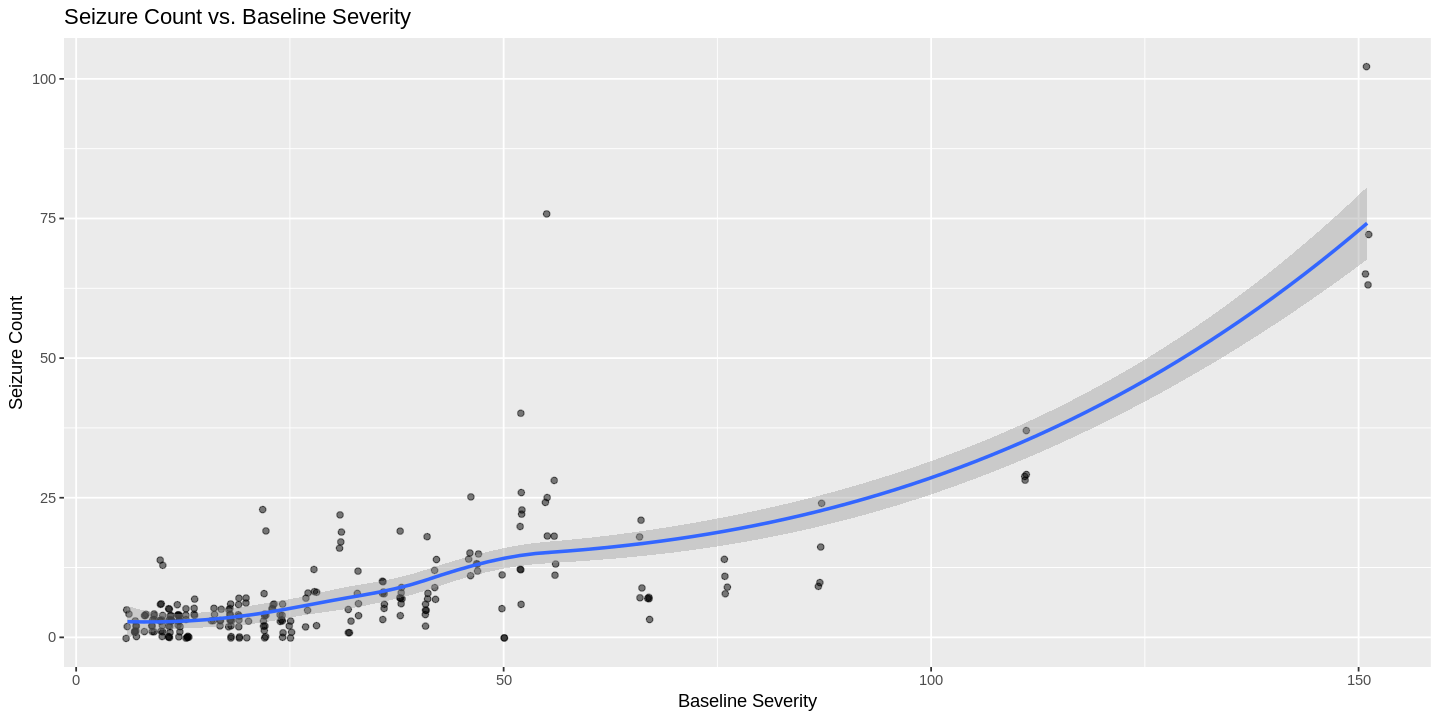

In [11]:
# Relationship between baseline severity and counts
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(epil, aes(x = base, y = y)) +
    geom_jitter(width = 0.2, height = 0.2, alpha = 0.5) +
    geom_smooth(method = "loess") +
    labs(
      title = "Seizure Count vs. Baseline Severity",
      x = "Baseline Severity",
      y = "Seizure Count"
    )

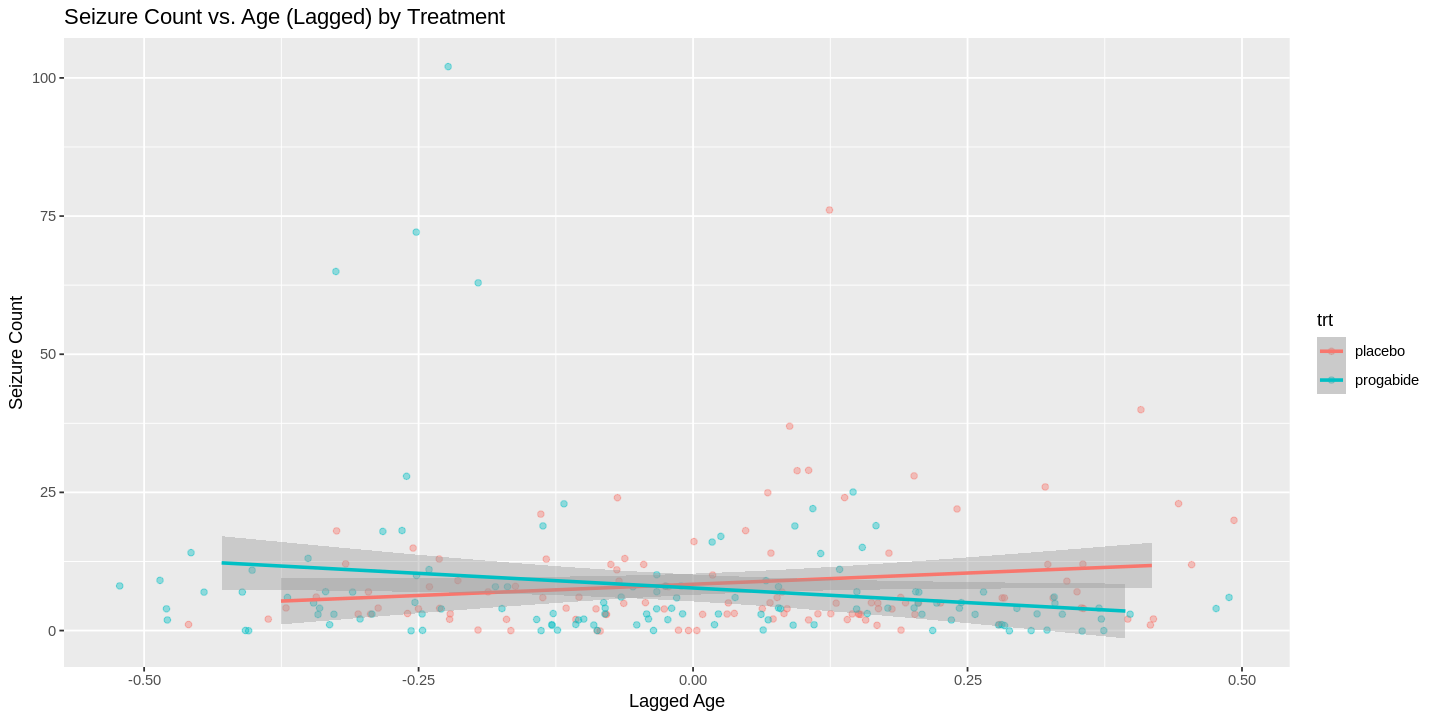

In [12]:
# Conditional density of age (lagged) by treatment vs. counts
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(epil, aes(x = lage, y = y, color = trt)) +
    geom_jitter(width = 0.1, height = 0.1, alpha = 0.4) +
    geom_smooth(method = "gam", formula = y ~ s(x, k = 5)) +
    labs(
      title = "Seizure Count vs. Age (Lagged) by Treatment",
      x = "Lagged Age",
      y = "Seizure Count"
    )

# Model Fitting

In [13]:
# Fit glmer Laplace
fit_laplace <- glmer(
    y ~ 1 + (1 | subject),
    data = epil,
    family = poisson,
    nAGQ = 1
)

In [14]:
# Print summary
print(summary(fit_laplace))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: y ~ 1 + (1 | subject)
   Data: epil

      AIC       BIC    logLik -2*log(L)  df.resid 
   1406.5    1413.4    -701.2    1402.5       234 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2521 -0.7816 -0.1987  0.5988  6.8753 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.8911   0.944   
Number of obs: 236, groups:  subject, 59

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.6216     0.1276   12.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [15]:
# Fit glmer AGHQ
fit_aghq_glmer <- glmer(
    y ~ 1 + (1 | subject),
    data = epil,
    family = poisson,
    nAGQ = 15
)

In [16]:
# Print summary
print(summary(fit_aghq_glmer))

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 15) [glmerMod]
 Family: poisson  ( log )
Formula: y ~ 1 + (1 | subject)
   Data: epil

      AIC       BIC    logLik -2*log(L)  df.resid 
    640.1     647.0    -318.1     636.1       234 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2523 -0.7808 -0.1985  0.5990  6.8748 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.8946   0.9458  
Number of obs: 236, groups:  subject, 59

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.6213     0.1281   12.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [17]:
# Fit TMB MLE
cat(
'
#include <TMB.hpp>
template<class Type>
Type objective_function<Type>::operator() () {
    DATA_VECTOR(y);
    DATA_FACTOR(subject);

    int n_pat = subject.maxCoeff() + 1;
    int n_obs = y.size();

    PARAMETER(beta0);
    PARAMETER_VECTOR(u);
    PARAMETER(log_sigma);

    Type sigma = exp(log_sigma);

    REPORT(u);
    REPORT(sigma);

    // Build the negative log-likelihood
    Type nll = 0;
    for (int j = 0; j < n_pat; j++) {
        nll -= dnorm(u[j], Type(0.0), sigma, true);
    }
    for (int i = 0; i < n_obs; i++) {
        Type eta = beta0 + u[subject[i]];
        nll -= dpois(
            Type(y[i]),
            exp(eta),
            true
        );
    }
    return nll;
}
',
    file = "poisson_glmm.cpp"
)

In [18]:
# Fit TMB MLE (continued)
TMB::compile("poisson_glmm.cpp")
dyn.load(TMB::dynlib("poisson_glmm"))

tmb_data <- list(
    y = epil$y,
    subject = as.integer(epil$subject)-1
)

tmb_pars <- list(
    beta0 = 0,
    u = rep(0, length(unique(tmb_data$subject))),
    log_sigma = log(1)
)

obj <- TMB::MakeADFun(
    data = tmb_data,
    parameters = tmb_pars,
    random = "u",
    DLL = "poisson_glmm"
)

opt <- nlminb(
    start = obj$par,
    objective = obj$fn,
    gradient = obj$gr
)

using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’



[1] 0

Constructing atomic D_lgamma
Constructing atomic D_lgamma
Constructing atomic D_lgamma
Optimizing tape... Done
iter: 1  value: 1918.776 mgc: 298 ustep: 0.01776843 
iter: 2  value: 1515.094 mgc: 264.0582 ustep: 0.133385 
iter: 3  value: 832.7153 mgc: 253.6318 ustep: 0.3652825 
iter: 4  value: 742.4503 mgc: 74.40214 ustep: 0.6044256 
iter: 5  value: 738.9726 mgc: 14.48855 ustep: 0.7774704 
iter: 6  value: 738.9615 mgc: 0.9613766 ustep: 0.8817547 
iter: 7  value: 738.9615 mgc: 0.006215079 ustep: 0.939024 
iter: 8  value: 738.9615 mgc: 5.611384e-05 ustep: 0.9690356 
iter: 9  value: 738.9615 mgc: 8.029437e-07 ustep: 0.9843976 
iter: 10  mgc: 5.73781e-09 
iter: 1  mgc: 5.73781e-09 
Matching hessian patterns... Done
outer mgc:  138.5334 
iter: 1  value: 710.0469 mgc: 209.3858 ustep: 1 
iter: 2  value: 698.6767 mgc: 37.59453 ustep: 1 
iter: 3  value: 698.642 mgc: 2.008194 ustep: 1 
iter: 4  value: 698.642 mgc: 0.00662542 ustep: 1 
iter: 5  value: 698.642 mgc: 9.256576e-06 ustep: 1 
iter: 6  mg

In [19]:
# Print the report
sdr <- TMB::sdreport(obj)
cat("\n")
print(summary(sdr))

iter: 1  mgc: 1.283418e-13 
outer mgc:  1.734685e-05 
iter: 1  value: 663.8081 mgc: 0.2991286 ustep: 1 
iter: 2  value: 663.8081 mgc: 0.0001483257 ustep: 1 
iter: 3  mgc: 3.643308e-11 
outer mgc:  0.06157401 
iter: 1  value: 663.8117 mgc: 0.2988296 ustep: 1 
iter: 2  value: 663.8117 mgc: 0.000148422 ustep: 1 
iter: 3  mgc: 3.650147e-11 
outer mgc:  0.06156618 
iter: 1  value: 663.8158 mgc: 0.006035869 ustep: 1 
iter: 2  value: 663.8158 mgc: 2.218501e-06 ustep: 1 
iter: 3  mgc: 4.7784e-13 
outer mgc:  0.09703002 
iter: 1  value: 663.8041 mgc: 0.006047953 ustep: 1 
iter: 2  value: 663.8041 mgc: 2.223733e-06 ustep: 1 
iter: 3  mgc: 4.787282e-13 
outer mgc:  0.09721434 

             Estimate Std. Error
beta0      1.62155360  0.1278546
log_sigma -0.05754647  0.1017987
u         -0.34176920  0.2801602
u         -0.34176920  0.2801602
u         -0.55489793  0.3032706
u         -0.40826912  0.2871140
u          0.97930555  0.1842805
u          0.07914977  0.2412978
u         -0.47911895  0.29

In [20]:
# # Fit TMB AGHQ Bayesian
# quad <- aghq::marginal_laplace_tmb(
#     obj,
#     k = 7,
#     startingvalue = opt$par
# )

In [21]:
# Define helper to silence output
quiet_marginal_laplace <- function(...) {
    suppressMessages(
        suppressWarnings(
            invisible(
                capture.output(
                    res <- aghq::marginal_laplace_tmb(...),
                    file = NULL
                )
            )
        )
    )
    return(res)
}

# Fit TMB AGHQ Bayesian quietly
quad <- quiet_marginal_laplace(
    obj,
    k = 7,
    startingvalue = opt$par
)

In [22]:
# Print summaries
post <- summary(
    quad,
    M = 1000,
    max_print = 60
)

print(post$aghqsummary)
cat("\n")
print(post$randomeffectsummary)

AGHQ on a 2 dimensional posterior with  7 7 quadrature points

The posterior mode is: 1.621554 -0.05754647 

The log of the normalizing constant/marginal likelihood is: -703.7398 

The covariance matrix used for the quadrature is...
             [,1]         [,2]
[1,]  0.016346802 -0.001043878
[2,] -0.001043878  0.010362973

Here are some moments and quantiles for the transformed parameter:

                mean        sd       2.5%      median    97.5%
beta0      1.6201915 0.1313033  1.3575585  1.61867365 1.874029
log_sigma -0.0397603 0.1033384 -0.2371673 -0.04455262 0.167935


           mean        sd         2.5%       median        97.5% variable
1  -0.348173547 0.2845776 -0.948765150 -0.346875946  0.207367729        u
2  -0.330446851 0.2818781 -0.881679235 -0.330178427  0.225156095        u
3  -0.542112270 0.3053103 -1.147973181 -0.553212258  0.050270535        u
4  -0.397211275 0.2763069 -0.913889944 -0.404349130  0.168720759        u
5   0.988120468 0.1857803  0.619934384  0.98

# Model Summarization

In [23]:
# glmer (Laplace)
lap_beta0 <- unname(
    fixef(fit_laplace)["(Intercept)"]
)

lap_se_b0 <- sqrt(
    vcov(fit_laplace)[1, 1]
)

lap_sigma <- attr(
    VarCorr(fit_laplace)$subject,
    "stddev"
)

ci_lap <- confint(
    fit_laplace,
    parm = "theta_",
    method = "Wald"
)

if (any(is.na(ci_lap))) {
    ci_lap <- confint(
        fit_laplace,
        parm = "theta_",
        method = "profile"
    )
}

lap_se_sigma <- (
    ci_lap[1, 2] - ci_lap[1, 1]
) / (2 * qnorm(0.975))

lap_est <- tibble(
    model = "glmer (Laplace)",
    beta0 = lap_beta0,
    se_beta0 = lap_se_b0,
    sigma = lap_sigma,
    se_sigma = lap_se_sigma
)

Computing profile confidence intervals ...



In [24]:
# glmer (AGHQ15)
aghq_beta0 <- unname(
    fixef(fit_aghq_glmer)["(Intercept)"]
)

aghq_se_b0 <- sqrt(
    vcov(fit_aghq_glmer)[1, 1]
)

aghq_sigma <- attr(
    VarCorr(fit_aghq_glmer)$subject,
    "stddev"
)

ci_agq <- confint(
    fit_aghq_glmer,
    parm = "theta_",
    method = "Wald"
)

if (any(is.na(ci_agq))) {
    ci_agq <- confint(
        fit_aghq_glmer,
        parm = "theta_",
        method = "profile"
    )
}

aghq_se_sigma <- (
    ci_agq[1, 2] - ci_agq[1, 1]
) / (2 * qnorm(0.975))

aghq_glmer_est <- tibble(
    model = "glmer (AGHQ15)",
    beta0 = aghq_beta0,
    se_beta0 = aghq_se_b0,
    sigma = aghq_sigma,
    se_sigma = aghq_se_sigma
)

Computing profile confidence intervals ...



In [25]:
# TMB (MLE)
sdr_sum <- summary(sdr)

mle_beta0 <- sdr_sum["beta0", "Estimate"]
mle_se_b0 <- sdr_sum["beta0", "Std. Error"]

log_sigma_est <- sdr_sum["log_sigma", "Estimate"]
se_log_sigma <- sdr_sum["log_sigma", "Std. Error"]

sigma_est <- exp(log_sigma_est)
se_sigma <- sigma_est * se_log_sigma

tmb_mle_est <- tibble(
    model = "TMB (MLE)",
    beta0 = mle_beta0,
    se_beta0 = mle_se_b0,
    sigma = sigma_est,
    se_sigma = se_sigma
)

In [26]:
# TMB (AGHQ7)
bayes_tbl <- post$aghqsummary$summarytable

b0_mean <- bayes_tbl["beta0", "mean"]
b0_sd <- bayes_tbl["beta0", "sd"]

log_sigma_mean <- bayes_tbl["log_sigma", "mean"]
log_sigma_sd <- bayes_tbl["log_sigma", "sd"]

sigma_mean <- exp(log_sigma_mean)
sigma_se <- sigma_mean * log_sigma_sd

tmb_aghq_est <- tibble(
    model = "TMB (AGHQ7)",
    beta0 = b0_mean,
    se_beta0 = b0_sd,
    sigma = sigma_mean,
    se_sigma = sigma_se
)

In [27]:
# Bind them all together
comparison <- bind_rows(
    lap_est,
    aghq_glmer_est,
    tmb_mle_est,
    tmb_aghq_est
)

print(comparison)

# A tibble: 4 × 5
  model           beta0 se_beta0 sigma se_sigma
  <chr>           <dbl>    <dbl> <dbl>    <dbl>
1 glmer (Laplace)  1.62    0.128 0.944   0.0980
2 glmer (AGHQ15)   1.62    0.128 0.946   0.0983
3 TMB (MLE)        1.62    0.128 0.944   0.0961
4 TMB (AGHQ7)      1.62    0.131 0.961   0.0993


# Model Evaluation

## RMSE & MAE

In [28]:
# Get fitted values
fitted_laplace <- fitted(fit_laplace)
fitted_aghq_glmer <- fitted(fit_aghq_glmer)

In [29]:
# TMB (MLE) fitted values
# 1) Grab the summary matrix
# rownames(sdr_sum) will be: "beta0", "log_sigma", then 59 rows named "u"
sdr_sum <- summary(sdr)

# 2) Extract beta0
beta0_mle <- sdr_sum["beta0", "Estimate"]

# 3) Extract all the u's
u_rows <- which(rownames(sdr_sum) == "u")
u_hat_mle <- sdr_sum[u_rows, "Estimate"]

# Sanity check
length(u_hat_mle)  # should be 59

# 4) Build the fitted values
fitted_tmb_mle <- exp(
    beta0_mle +
    u_hat_mle[tmb_data$subject + 1]
)

[1] 59

In [30]:
# TMB (AGHQ7) fitted values
# 1) Extract the fixed-intercept posterior mean
b0_mean <- post$aghqsummary$summarytable[
    "beta0", "mean"
]

# 2) Extract the posterior-mean random effects
u_hat_aghq <- post$randomeffectsummary$mean

# Sanity check
length(u_hat_aghq)  # should be 59

# 3) Build the fitted values
fitted_tmb_aghq <- exp(
    b0_mean +
    u_hat_aghq[tmb_data$subject + 1]
)

[1] 59

In [31]:
# Compute RMSE and MAE
metrics_df <- tibble(
    model = c(
        "glmer (Laplace)",
        "glmer (AGHQ15)",
        "TMB (MLE)",
        "TMB (AGHQ7)"
    ),
    RMSE = c(
        rmse(epil$y, fitted_laplace),
        rmse(epil$y, fitted_aghq_glmer),
        rmse(epil$y, fitted_tmb_mle),
        rmse(epil$y, fitted_tmb_aghq)
    ),
    MAE = c(
        mae(epil$y, fitted_laplace),
        mae(epil$y, fitted_aghq_glmer),
        mae(epil$y, fitted_tmb_mle),
        mae(epil$y, fitted_tmb_aghq)
    )
)

metrics_df

model,RMSE,MAE
<chr>,<dbl>,<dbl>
glmer (Laplace),4.942424,2.690703
glmer (AGHQ15),4.942379,2.690705
TMB (MLE),4.942422,2.690702
TMB (AGHQ7),4.940373,2.702034


## AIC & BIC

In [32]:
# Information criteria for glmer models
ic_df <- tibble(
    model = c(
        "glmer (Laplace)",
        "glmer (AGHQ15)"
    ),
    AIC = c(
        AIC(fit_laplace),
        AIC(fit_aghq_glmer)
    ),
    BIC = c(
        BIC(fit_laplace),
        BIC(fit_aghq_glmer)
    ),
    logLik = c(
        as.numeric(logLik(fit_laplace)),
        as.numeric(logLik(fit_aghq_glmer))
    )
)

ic_df

model,AIC,BIC,logLik
<chr>,<dbl>,<dbl>,<dbl>
glmer (Laplace),1406.4960,1413.4236,-701.2480
glmer (AGHQ15),640.1116,647.0393,-318.0558


In [33]:
# Information criteria for TMB (MLE)
n_par_mle <- length(opt$par)
nll_mle <- obj$fn(opt$par)
aic_mle <- 2 * n_par_mle + 2 * nll_mle
bic_mle <- log(nrow(epil)) * n_par_mle + 2 * nll_mle

ic_df <- bind_rows(
    ic_df,
    tibble(
        model = "TMB (MLE)",
        AIC = aic_mle,
        BIC = bic_mle,
        logLik = -nll_mle
    )
)

cat("\n")
ic_df

iter: 1  value: 663.8099 mgc: 7.750555e-08 ustep: 1 
mgc: 1.283418e-13 



model,AIC,BIC,logLik
<chr>,<dbl>,<dbl>,<dbl>
glmer (Laplace),1406.4960,1413.4236,-701.2480
glmer (AGHQ15),640.1116,647.0393,-318.0558
TMB (MLE),1406.4958,1413.4235,-701.2479


In [34]:
# Compute approximate AIC/BIC for AGHQ TMB fit
mll_aghq <- get_log_normconst(quad)

k_fix <- 2
n_obs <- nrow(epil)

aic_aghq <- -2 * mll_aghq + 2 * k_fix
bic_aghq <- -2 * mll_aghq + k_fix * log(n_obs)

# Add AGHQ row to information criteria table
ic_df <- bind_rows(
    ic_df,
    tibble(
        model = "TMB (AGHQ7)",
        AIC = aic_aghq,
        BIC = bic_aghq,
        logLik = mll_aghq
    )
)
cat("TMB (AGHQ7) is Bayesian, so its IC results are just a low-fidelity approximation.\n\n")
ic_df

TMB (AGHQ7) is Bayesian, so its IC results are just a low-fidelity approximation.



model,AIC,BIC,logLik
<chr>,<dbl>,<dbl>,<dbl>
glmer (Laplace),1406.4960,1413.4236,-701.2480
glmer (AGHQ15),640.1116,647.0393,-318.0558
TMB (MLE),1406.4958,1413.4235,-701.2479
TMB (AGHQ7),1411.4796,1418.4073,-703.7398


## Nakagawa R2

In [35]:
# glmer Nakagawa R2
r2_lap <- r2_nakagawa(fit_laplace)
r2_agq <- r2_nakagawa(fit_aghq_glmer)

In [36]:
# Extract TMB variances from TMB (MLE) fit
sigma_mle <- exp(sdr_sum["log_sigma", "Estimate"])
beta0_mle <- sdr_sum["beta0", "Estimate"]

In [37]:
# Extract TMB variances from TMB (AGHQ7) posterior means
sigma_aghq <- exp(bayes_tbl["log_sigma", "mean"])
beta0_aghq <- bayes_tbl["beta0", "mean"]

In [38]:
# Helper to compute R2 for a given (beta0, sigma)
compute_r2_tmb <- function(beta0, sigma) {
    # Marginal mean on response scale
    mu <- exp(beta0 + 0.5 * sigma^2)
    var_u <- sigma^2
    var_e <- log(1 + 1 / mu)
    r2_marg <- 0
    r2_cond <- var_u / (var_u + var_e)
    c(R2_marginal = r2_marg, R2_conditional = r2_cond)
}

In [39]:
# TMB Nakagawa R2
r2_mle <- compute_r2_tmb(beta0_mle, sigma_mle)
r2_aghq <- compute_r2_tmb(beta0_aghq, sigma_aghq)

In [40]:
# Combine into one table
r2_df <- tibble(
    model = c(
        "glmer (Laplace)",
        "glmer (AGHQ15)",
        "TMB (MLE)",
        "TMB (AGHQ7)"
    ),
    R2_marginal = c(
        r2_lap$R2_marginal,
        r2_agq$R2_marginal,
        r2_mle["R2_marginal"],
        r2_aghq["R2_marginal"]
    ),
    R2_conditional = c(
        r2_lap$R2_conditional,
        r2_agq$R2_conditional,
        r2_mle["R2_conditional"],
        r2_aghq["R2_conditional"]
    )
)

r2_df

model,R2_marginal,R2_conditional
<chr>,<dbl>,<dbl>
glmer (Laplace),0,0.8820624
glmer (AGHQ15),0,0.8825965
TMB (MLE),0,0.8820793
TMB (AGHQ7),0,0.8871322


## DHARMa Residuals

In [41]:
# glmer models (Laplace and AGHQ15)
sim_laplace <- simulateResiduals(
    fittedModel = fit_laplace,
    n = 1000
)

sim_aghq_glmer <- simulateResiduals(
    fittedModel = fit_aghq_glmer,
    n = 1000
)

In [42]:
# TMB (MLE)
# Simulate 1000 replicate datasets from Poisson with fitted_tmb_mle
sims_mle <- replicate(
    1000,
    rpois(
        n = length(fitted_tmb_mle),
        lambda = fitted_tmb_mle
    )
)

sim_tmb_mle <- createDHARMa(
    simulatedResponse = sims_mle,
    observedResponse = epil$y,
    fittedPredictedResponse = fitted_tmb_mle,
    integerResponse = TRUE
)

In [43]:
# TMB (AGHQ7)
# Simulate 1000 replicate datasets from Poisson with fitted_tmb_aghq
sims_aghq <- replicate(
    1000,
    rpois(
        n = length(fitted_tmb_aghq),
        lambda = fitted_tmb_aghq
    )
)

sim_tmb_aghq <- createDHARMa(
    simulatedResponse = sims_aghq,
    observedResponse = epil$y,
    fittedPredictedResponse = fitted_tmb_aghq,
    integerResponse = TRUE
)

glmer (Laplace):



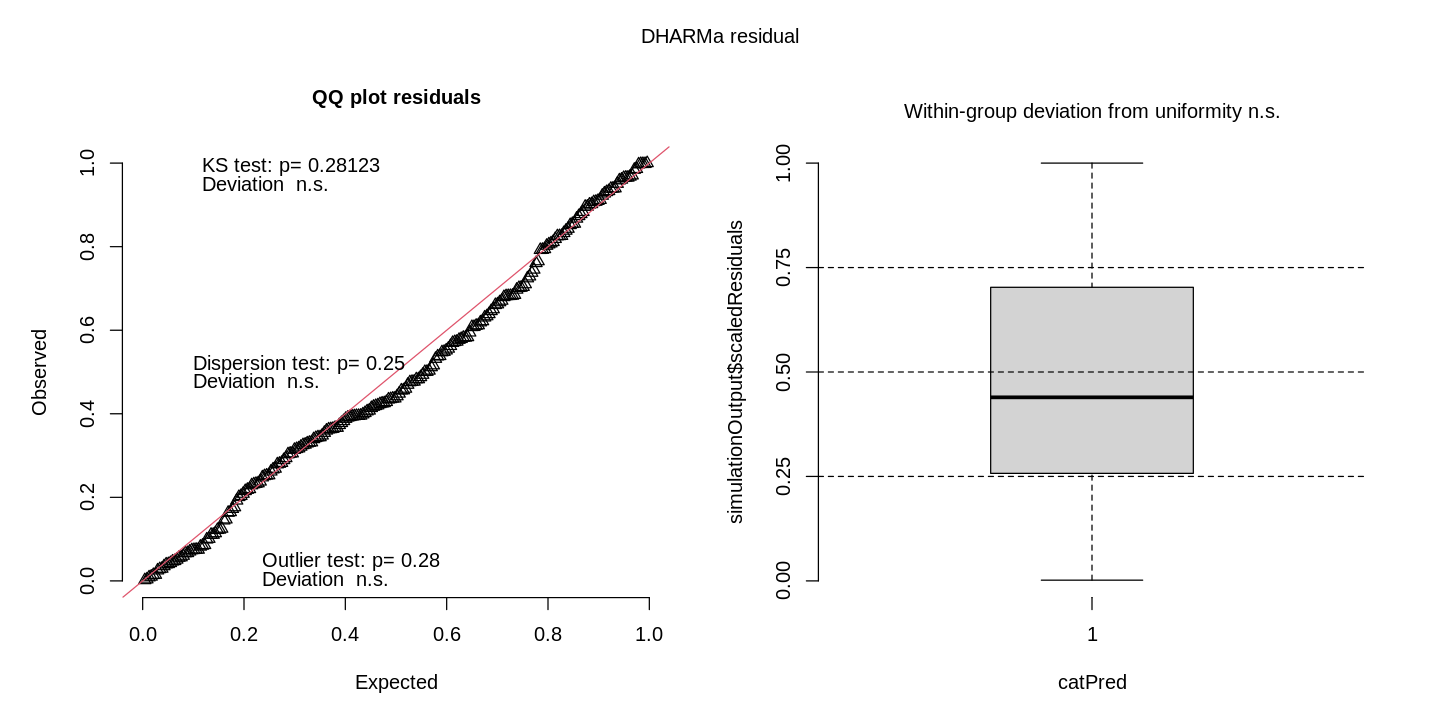

In [44]:
# Plot for glmer (Laplace)
cat("glmer (Laplace):")
cat("\n\n")
plot(sim_laplace)

glmer (AGHQ15):



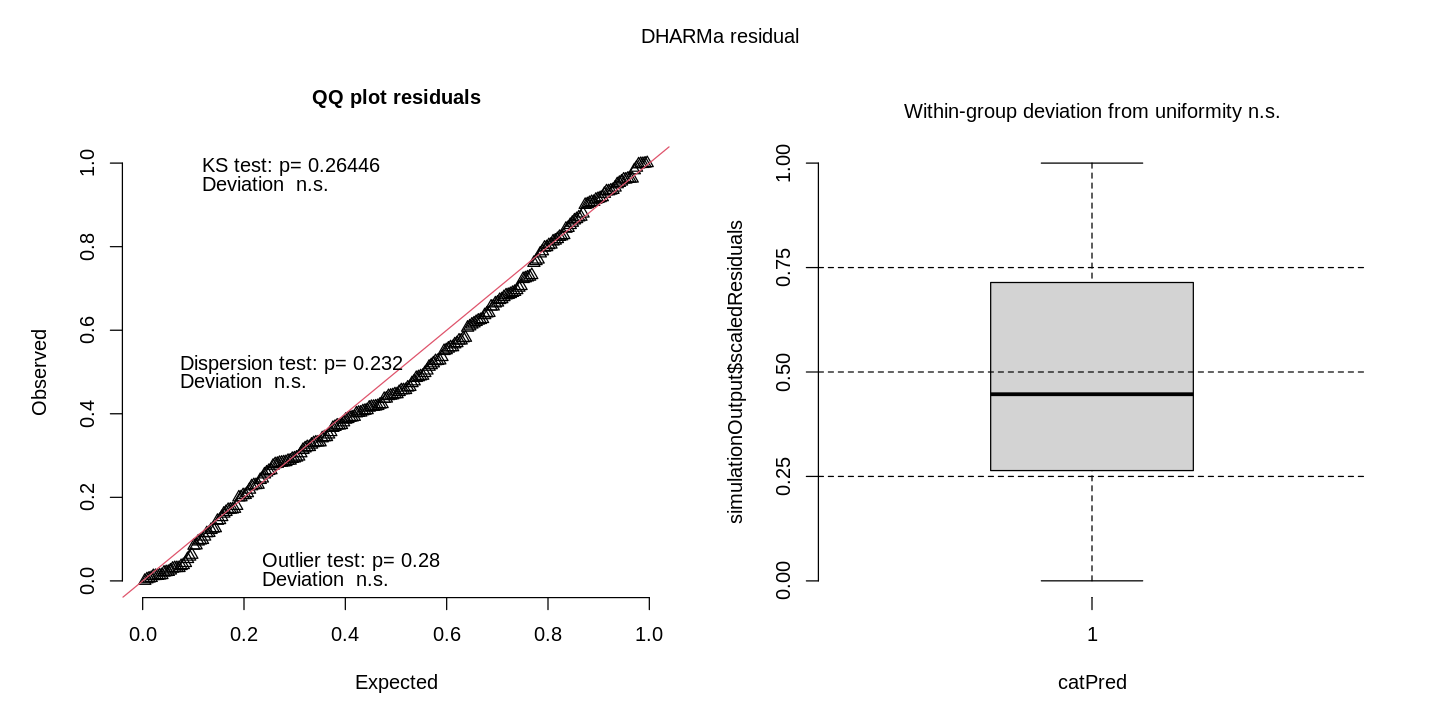

In [45]:
# Plot for glmer (AGHQ15)
cat("glmer (AGHQ15):")
cat("\n\n")
plot(sim_aghq_glmer)

TMB (MLE):



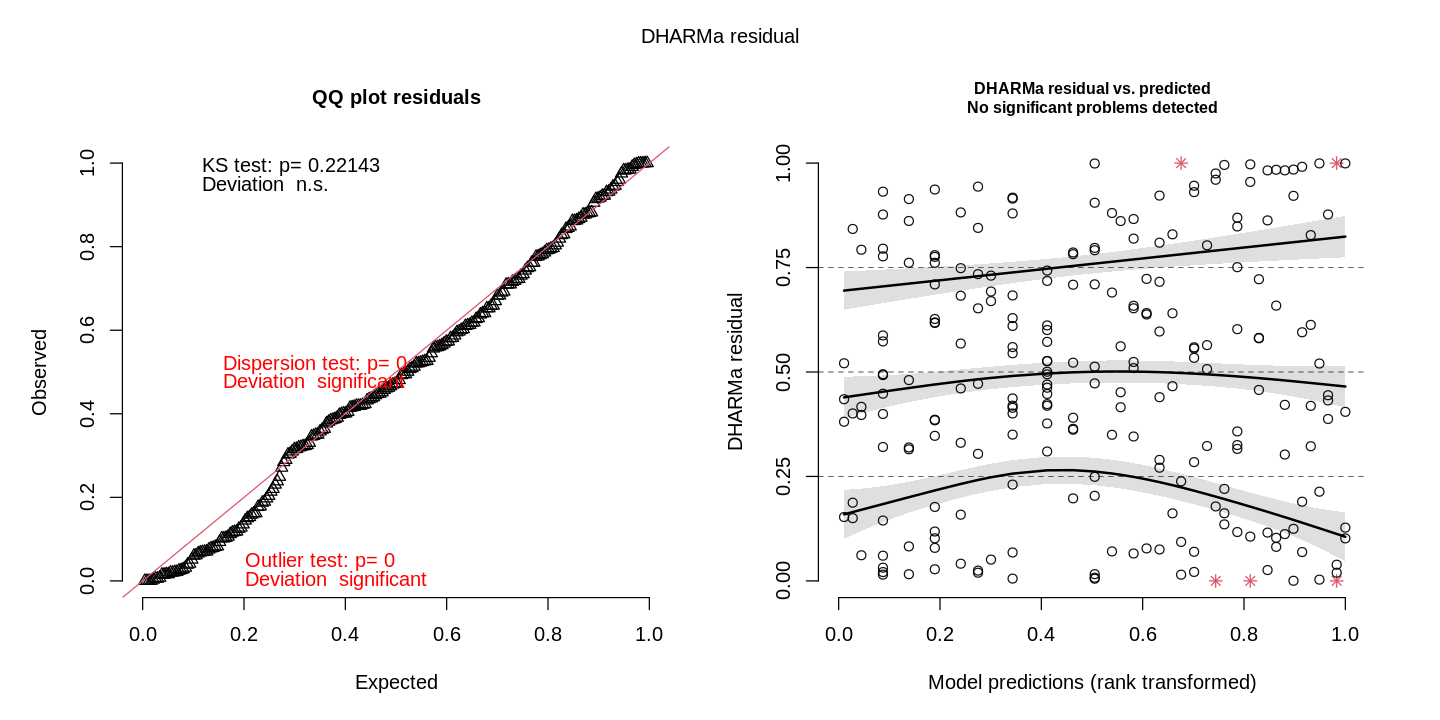

In [46]:
# Plot for TMB (MLE)
cat("TMB (MLE):")
cat("\n\n")
plot(sim_tmb_mle)

TMB (AGHQ7):



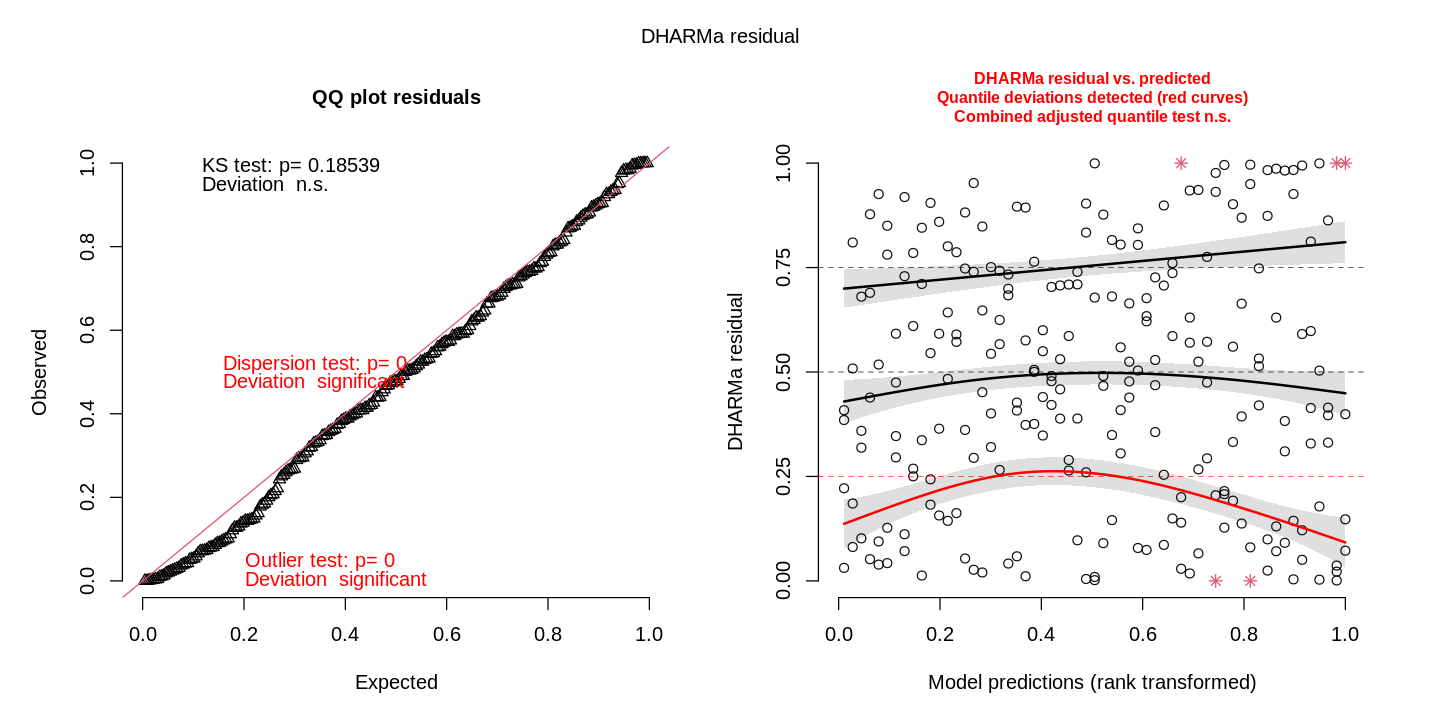

In [47]:
# Plot for TMB (AGHQ7)
cat("TMB (AGHQ7):")
cat("\n\n")
plot(sim_tmb_aghq)